Before feature engineering:
['Timestamp', 'IP_Address', 'Request_Type', 'Status_Code', 'Anomaly_Flag', 'User_Agent', 'Session_ID', 'Location']
Shape: (10000, 8)

After feature engineering:
['Timestamp', 'IP_Address', 'Request_Type', 'Status_Code', 'Anomaly_Flag', 'User_Agent', 'Session_ID', 'Location', 'hour', 'day_of_week', 'is_weekend', 'is_night', 'is_business_hours', 'requests_per_ip', 'failed_requests_per_ip', 'failure_rate', 'is_client_error', 'is_server_error', 'is_error', 'is_success', 'suspicious_user_agent', 'is_post', 'is_get', 'risk_score']
Shape: (10000, 24)

Sample with new features:
        IP_Address  requests_per_ip  failure_rate  risk_score  Anomaly_Flag
0   202.118.116.11                1           1.0         6.0             0
1     38.30.40.178                1           0.0         0.0             0
2     209.5.148.15                1           1.0         6.0             0
3    211.116.60.71                1           0.0         0.0             0
4   170.166.36.

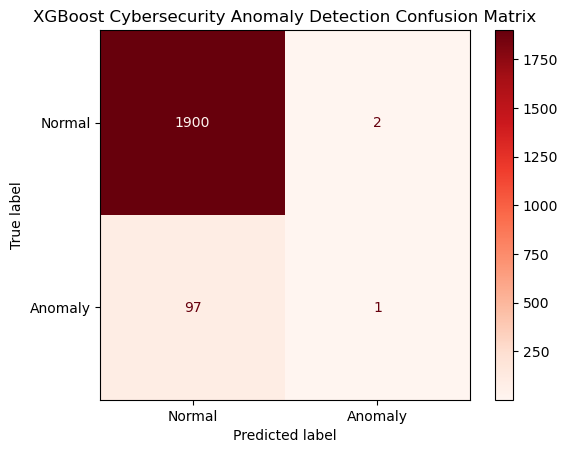


Classification Report:
              precision    recall  f1-score   support

  Normal (0)       0.95      1.00      0.97      1902
 Anomaly (1)       0.33      0.01      0.02        98

    accuracy                           0.95      2000
   macro avg       0.64      0.50      0.50      2000
weighted avg       0.92      0.95      0.93      2000


Top 10 Feature Importances:
is_success                0.199674
is_server_error           0.073720
is_error                  0.073182
hour                      0.071270
day_of_week               0.068553
failure_rate              0.064725
is_client_error           0.064412
is_post                   0.063247
failed_requests_per_ip    0.057825
is_get                    0.057139
dtype: float32


In [27]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import xgboost as xgb

def engineer_features(df):
    """
    Create advanced features for threat detection
    """
    df = df.copy()
    # Convert timestamp to datetime
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    # TIME-BASED FEATURES
    df['hour'] = df['Timestamp'].dt.hour
    df['day_of_week'] = df['Timestamp'].dt.dayofweek
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    df['is_night'] = ((df['hour'] < 6) | (df['hour'] > 22)).astype(int)
    df['is_business_hours'] = ((df['hour'] >= 9) & (df['hour'] <= 17)).astype(int)
    
    # IP-BASED FEATURES
    ip_counts = df.groupby('IP_Address').size()
    df['requests_per_ip'] = df['IP_Address'].map(ip_counts)
    
    failed = df[df['Status_Code'] >= 400].groupby('IP_Address').size()
    df['failed_requests_per_ip'] = df['IP_Address'].map(failed).fillna(0)
    
    df['failure_rate'] = df['failed_requests_per_ip'] / df['requests_per_ip']
    df['failure_rate'] = df['failure_rate'].fillna(0)
    
    # STATUS CODE FEATURES
    df['is_client_error'] = ((df['Status_Code'] >= 400) & (df['Status_Code'] < 500)).astype(int)
    df['is_server_error'] = (df['Status_Code'] >= 500).astype(int)
    df['is_error'] = (df['Status_Code'] >= 400).astype(int)
    df['is_success'] = (df['Status_Code'] < 400).astype(int)
    
    # USER AGENT FEATURES
    suspicious_agents = ['curl', 'python', 'wget', 'nmap', 'sqlmap', 'nikto', 'scrapy', 'Bot']
    df['suspicious_user_agent'] = df['User_Agent'].apply(
        lambda x: 1 if any(agent in str(x).lower() for agent in suspicious_agents) else 0
    )
    
    # HTTP METHOD FEATURES
    df['is_post'] = (df['Request_Type'] == 'POST').astype(int)
    df['is_get'] = (df['Request_Type'] == 'GET').astype(int)
    
    # (Optional: you can keep risk_score for comparison, but it's not used in the model)
    df['risk_score'] = (df['suspicious_user_agent'] * 3 + df['failure_rate'] * 5 + df['is_error'] * 1)
    
    return df

if __name__ == "__main__":
    df = pd.read_csv("advanced_cybersecurity_data.csv")
    
    print("Before feature engineering:")
    print(df.columns.tolist())
    print(f"Shape: {df.shape}")
    
    # Engineer features
    df_enhanced = engineer_features(df)
    
    print("\nAfter feature engineering:")
    print(df_enhanced.columns.tolist())
    print(f"Shape: {df_enhanced.shape}")
    
    # Show sample
    print("\nSample with new features:")
    print(df_enhanced[['IP_Address', 'requests_per_ip', 'failure_rate', 'risk_score', 'Anomaly_Flag']].head(10))
    
    # === XGBoost Model for Anomaly Detection ===
    print("\n=== Training XGBoost Classifier ===")
    
    # Select feature columns (exclude non-numeric or target/leakage columns)
    feature_cols = [
        'hour', 'day_of_week', 'is_weekend', 'is_night', 'is_business_hours',
        'requests_per_ip', 'failed_requests_per_ip', 'failure_rate',
        'is_client_error', 'is_server_error', 'is_error', 'is_success',
        'suspicious_user_agent', 'is_post', 'is_get'
        # Add more if you engineer additional numeric features (e.g., response_time_zscore)
    ]
    
    X = df_enhanced[feature_cols]
    y = df_enhanced['Anomaly_Flag']
    
    # Split data (stratified to maintain class balance)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Train XGBoost model (removed deprecated use_label_encoder parameter)
    model = xgb.XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='logloss'
    )
    model.fit(X_train, y_train)
    
    # Predictions on test set
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For potential threshold tuning
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anomaly'])
    disp.plot(cmap='Reds')
    plt.title('XGBoost Cybersecurity Anomaly Detection Confusion Matrix')
    plt.show()
    
    # Additional metrics
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Normal (0)', 'Anomaly (1)']))
    
    # Feature importance
    print("\nTop 10 Feature Importances:")
    importances = pd.Series(model.feature_importances_, index=feature_cols)
    print(importances.sort_values(ascending=False).head(10))